# How can we reach the equilibrium in a predator-prey habitat?
In this Notebook we will try to understand the evolution and interactions in a predator-prey habitat and how to reach the equilibrium of the prey and predator populations.For this purpose we will use a predator-prey model and Global Sensitivity Analysis (GSA).

# What is a predator-prey habitat?
In a predator-prey habiat we consider two species. One species, the prey, is the primary source of food source for the other, the predator. The predator-prey food chain persists over time thanks to a **negative feedback loop**, i.e. when the product of a reaction leads to a decrease in that reaction. When predators eat preys, they reduce their population but this drop in the predators food source will soon cause the predator population to decline. This will also reduce the predation rate allowing the prey population to increase again. This cycle creates an up and down wavelike pattern that maintain a long-term equilibrium.

<left><img src="util/predator_prey_equil.gif" width="700px">

Now imagine that in a given natural habitat we would like to introduce a predator species to maintain the population of rabbits stable. For this purpose, we can select the initial number and species of predators as well as the initial number of rabbits. We could do this by trial and error by introducing different predator species and then monitoring the evolution of the populations but this will likely require high amounts of time, money and animal lives. But what if we could we simulate the habitat and its evolution on a computer using mathematical equations? 

A hydrological model is a mathematical model (set of equations) describing the hydrological processes that occur in a catchment as a function of various parameters. These model parameters describe the hydrological characteristics of the catchment, such as the climate and soil characteristics, ultimately enabling the estimation of the river flow at selected river sections.

# What is a predator-prey model?
A predator-prey model is a mathematical model (set of equations) describing the interactions that occur in a predator-prey habitat as a function of various parameters. These model parameters describe the characteristics of the habitat, such as the initial number of predators and preys and the characteristics of the predator species, ultimately enabling the estimation of the evolution in time of the predator and prey populations.

## Model parameters
- Initial number of predators
- Attack rate of predators: number of times that a predator attacks per week
- Efficiency rate of predators: number of encounters per week that resulted in a kill
- Death rate of predators: fraction of the predator population that dies per week
- Initial number of preys
- Growth rate of preys: number of preys that are born per week
- Carrying capacity of environment: maximum number of preys that the environment can sustain

## Model outputs
- Daily predator population
- Daily prey population


## Model assumptions
- The food supply of the predator population depends entirely on the size of the prey population.
- The rate of change of population is proportional to its size.
- Predators have limitless appetite.
- If the prey population grows beyond the carrying capacity of the environment, then their population would be wiped out as all the available food resources would have been consumed.
- Preys only die as a result of predator attacks.

Now, using the predator-prey model and changing the model parameters, let's try to **reach the equilibrium** of the predator and prey populations in **less than a year** and that at the equilibrium point there are **at least 5 individuals of each**.

In [1]:
from ipywidgets import widgets
from util.predator_prey_interactive import predator_prey_interactive

predator_ini,attack_rate,efficiency_rate,death_rate,prey_ini,growth_rate,carrying_capacity,fig1 = predator_prey_interactive()

widgets.VBox([widgets.VBox([predator_ini,attack_rate,efficiency_rate,death_rate,prey_ini],
                           layout=dict(border='solid',width = '550px',height = '180px')),fig1])

# What is Global Sensitivity Analysis? and why shall we use it?

**Global Sensitivity Analysis** is a set of mathematical techniques which investigate how uncertainty in the output of a numerical model can be attributed to variations of its input factors.

The benefits of applying GSA are:

1. **Better understanding of the model**
    
2. **Test whether the model "behaves well"**
    
3. **Identify the important inputs on which to focus computation time (e.g. for calibration), acquisition of new data, etc.** 
    
4. **Understand the main impacts of input uncertainty on the modelling outcome and thus model-informed decisions**

## How Global Sensitivity Analysis works?

GSA investigates how the uncertainty of the selected model input parameters influences the variability of the model output/performance.

A '**model parameter**' is any element that can be changed before running the model.

An '**output**' is any variable that is obtained after the model execution.

Before executing the model, we will sample the parameters from their ranges of variability and then repeatedly run the model so that for each simulation all the inputs vary simultaneously. After GSA is performed we obtain a set of sensitivity indices for each output. The sensitivity indices measure the relative influence of each input factor on the output (*Refs. 4-5*).

## Investigate interactions between model parameters
In order to investigate the interactions between input factors we plot one input against the other, coloured by the value taken by the output.

### a) Model output = predator population at equilibrium

### Step 1: Import python modules

In [2]:
from __future__ import division, absolute_import, print_function

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from ipywidgets import widgets
import warnings
warnings.filterwarnings('ignore')

from SAFEpython import PAWN
import SAFEpython.plot_functions as pf # module to visualize the results
from SAFEpython.model_execution import model_execution # module to execute the model
from SAFEpython.sampling import AAT_sampling, AAT_sampling_extend # module to perform the input sampling
from SAFEpython.util import aggregate_boot  # function to aggregate the bootstrap results

import util.predator_prey_model as predator_prey_model

### Step 2: Setup the model

Define: 
- the input factors whose influence is to be analysed with GSA, 
- their range of variability (choice made by expert judgement, available data or previous studies),
- choice of their distributions.

In [3]:
param_names  = ["Predator initial pop",
                "Predator attack rate",
                "Predator efficiency", 
                "Predator death rate", 
                "Prey initial pop"]
M = len(param_names) # number of parameters

# Parameter distributions:
distr_fun = st.uniform # uniform distribution
samp_strat = 'lhs' # Latin Hypercube
# The shape parameters of the uniform distribution are the lower limit and the difference between lower and upper limits:
distr_par  = [np.nan] * M

# Define output:
fun_test = predator_prey_model.function

Range of variability

In [4]:
data = [["-",  1,     10 ],
        ["-",  0.1,   1  ],
        ["-",  0.1,  1  ],
        ["-",  0.1,  1  ],
        ["-",  1,     10 ]]

model_param = pd.DataFrame(data, 
                           columns=["Unit", "Min value", "Max value"],
                           index = param_names)
model_param

,Unit,Min value,Max value
Predator initial pop,-,1.0,10
Predator attack rate,-,0.1,1
Predator efficiency,-,0.1,1
Predator death rate,-,0.1,1
Prey initial pop,-,1.0,10


In [5]:
outputs  = ["predator population",
            "prey population"]

model_outputs = pd.DataFrame(outputs, columns = ['model outputs'])
model_outputs

,model outputs
0,predator population
1,prey population


In [6]:
class setup_model:
    def __init__(self, x1, x2, x3, x4, x5):
        # The shape parameters of the uniform distribution are the lower limit and 
        # the difference between lower and upper limits:
        self.xmin = [x1.value[0], x2.value[0], x3.value[0], x4.value[0], x5.value[0]]
        self.xmax = [x1.value[1], x2.value[1], x3.value[1], x4.value[1], x5.value[1]]
        for i in range(M):
            distr_par[i] = [self.xmin[i], self.xmax[i] - self.xmin[i]]
        self.distr_par = distr_par

### Step 3: Sample inputs space

The number of model runs ($N$) typically increases proportionally to the number of input factors ($M$) and will depend on the GSA methods chosen as well. 

In [7]:
N = 2000 # number of samples
class sample_input:
    def __init__(self,distr_par):
        self.X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)

### Step 4: Run the model

For each sampled input factors combination, we run the model and save the associated model output.

In [8]:
T = 1000 # days
time_range = np.arange(1,T+1)
class run_model:
    def __init__(self,X):
        self.Y = model_execution(fun_test, X, T,output.value)

### Step 5: Apply the PAWN Global Sensitivity Analysis method
Let’s now apply Global Sensitivity Analysis: for example the **PAWN** method. 

Its main idea is that the influence of an input factor is proportional to the amount of change in the output distribution produced by fixing that input.
<br> The sensitivity of $y$ to $x_{i}$ is measured by the difference between the unconditional CDF of $y$: $F_y( y )$, which is induced by varying all input factors simultaneously, and the conditional CDF that is obtained by varying all inputs but $x_{i}$: $F_{y|x_i}( y | x_i )$.

### Step 6: Check model behaviour by visualising input/output samples
Scatterplots are plotted to visualise the behaviour of the output over each input factor in turn.

Definition of interactivity

In [9]:
def update_figures(change):
    with fig1.batch_update():
        distr_par = setup_model(x1, x2, x3, x4, x5).distr_par
        X = sample_input(distr_par).X
        Y = run_model(X).Y
        KS_median, _, _, KS_dummy = PAWN.pawn_indices(X, Y, n, dummy = True)

        for i in range(0,M):
            fig1.data[i].y = [KS_median[i]]
        fig1.data[i+1].y = KS_dummy
        fig1.layout.title = 'model output: <b>'+outputs[output.value]

Definition of the sliders

In [10]:
output = widgets.IntSlider(value = 0, min = 0, max = 1,
                              step = 1, description = 'output',
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              continuous_update=False)
output.observe(update_figures,names = 'value')

x1 = widgets.IntRangeSlider(value = [model_param['Min value'][0], model_param['Max value'][0]], min = model_param['Min value'][0], max = model_param['Max value'][0],
                              step = 1, description = model_param.index[0], 
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              continuous_update=False)
x1.observe(update_figures,names = 'value')

x2 = widgets.FloatRangeSlider(value = [model_param['Min value'][1], model_param['Max value'][1]], min = model_param['Min value'][1], max = model_param['Max value'][1], 
                              step = 0.1, description = model_param.index[1],
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              readout_format = '.1f', continuous_update=False)
x2.observe(update_figures,names = 'value')

x3 = widgets.FloatRangeSlider(value = [model_param['Min value'][2], model_param['Max value'][2]], min = model_param['Min value'][2], max = model_param['Max value'][2], 
                              step = 0.1, description = model_param.index[2],
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              readout_format = '.1f', continuous_update=False)
x3.observe(update_figures,names = 'value')

x4 = widgets.FloatRangeSlider(value = [model_param['Min value'][3], model_param['Max value'][3]], min = model_param['Min value'][3], max = model_param['Max value'][3], 
                              step = 0.1, description = model_param.index[3], 
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              readout_format = '.1f', continuous_update=False)
x4.observe(update_figures,names = 'value')

x5 = widgets.IntRangeSlider(value = [model_param['Min value'][4], model_param['Max value'][4]], min = model_param['Min value'][4], max = model_param['Max value'][4], 
                              step = 1, description = model_param.index[4], 
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              continuous_update=False)
x5.observe(update_figures,names = 'value')

### Step 8: Plot sensitivity indices and identify non-influential parameters

The dummy parameter is a numerical artifice, with no influence on the model output, which is used to estimate the threshold for non-influential inputs. 

Uninfluential input factors should have zero-valued sensitivity indices, but since sensitivity indices are computed by numerical approximations rather than analytical solutions, an uninfluential factor may still be associated with a non-zero (although small) index value. 

Therefore if the index of an input factor is below the value of the sensitivity index of the dummy parameter, then the input factor is deemed uninfluential *(Ref. 6)*.

In [11]:
n=10
distr_par = setup_model(x1, x2, x3, x4, x5).distr_par
X = sample_input(distr_par).X
Y = run_model(X).Y
KS_median, _, _, KS_dummy = PAWN.pawn_indices(X, Y, n, dummy = True)

In [12]:
fig1 = go.FigureWidget(layout = dict(width=700, height=500,showlegend = False, 
                                     title = 'model output: <b>'+outputs[output.value]))
fig1.add_trace(go.Box(y=[KS_median[0]], name = model_param.index[0]))
fig1.add_trace(go.Box(y=[KS_median[1]], name = model_param.index[1]))
fig1.add_trace(go.Box(y=[KS_median[2]], name = model_param.index[2]))
fig1.add_trace(go.Box(y=[KS_median[3]], name = model_param.index[3]))
fig1.add_trace(go.Box(y=[KS_median[4]], name = model_param.index[4]))
fig1.add_trace(go.Box(y=KS_dummy, name = 'dummy'))
fig1.layout.yaxis.range=[0,1]

In [13]:
widgets.VBox([widgets.VBox([widgets.VBox([output,x1,x2,x3,x4,x5]),fig1])])

### Step 11: Investigate interactions between input factors

In order to investigate the interactions between input factors we plot one input against the other, coloured by the value taken by the output.

### a) Model output = predator population at equilibrium

In [14]:
pd.DataFrame(param_names,columns=["parameters"],
                           index = ["X1", "X2", "X3", "X4", "X5"])

,parameters
X1,Predator initial pop
X2,Predator attack rate
X3,Predator efficiency
X4,Predator death rate
X5,Prey initial pop


In [15]:
output.value = 0
distr_par = setup_model(x1, x2, x3, x4, x5).distr_par
X = sample_input(distr_par).X
Y = run_model(X).Y

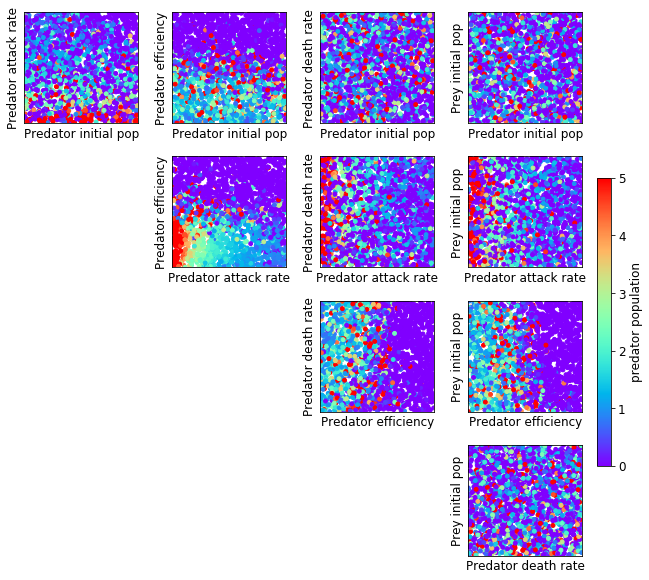

In [16]:
colorscale = 'rainbow' # black and white plot
ms=15
font_size = 12
Y = Y.flatten() # shape (N, )
Labels = [np.nan]*M
for i in range(M):
    Labels[i] = param_names[i]

fig2 = plt.figure(figsize=(10, 10))    
k = 1
for i in range(M-1):
    for j in range(i+1, M, 1):
        plt.subplot(M-1, M-1, k+i)
        map_plot = plt.scatter(X[:, i], X[:, j], s=ms, c=Y, cmap=colorscale,vmin=0, vmax=5)
        plt.xlabel(Labels[i], fontsize = font_size)
        plt.ylabel(Labels[j], fontsize = font_size)
        plt.xlim((np.min(X[:, i]), np.max(X[:, i])))
        plt.ylim((np.min(X[:, j]), np.max(X[:, j])))
        plt.xticks([])
        plt.yticks([])
        k = k + 1
    k = k + i
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.3, wspace=0.3)
# Create colorbar
cax = fig2.add_axes([0.92, 0.05, 0.02, 0.8]) # Add axes for the colorbar
cb = plt.colorbar(map_plot, ax=cax, fraction=1, extendfrac=1, extendrect=True)
cb.set_label(outputs[output.value], fontsize = font_size)
cb.ax.tick_params(labelsize=font_size)
# Make axes of the colorbar invisible
cax.set_visible(False)

### b) Model output = prey population at equilibrium

In [17]:
output.value = 1
distr_par = setup_model(x1, x2, x3, x4, x5).distr_par
X = sample_input(distr_par).X
Y = run_model(X).Y

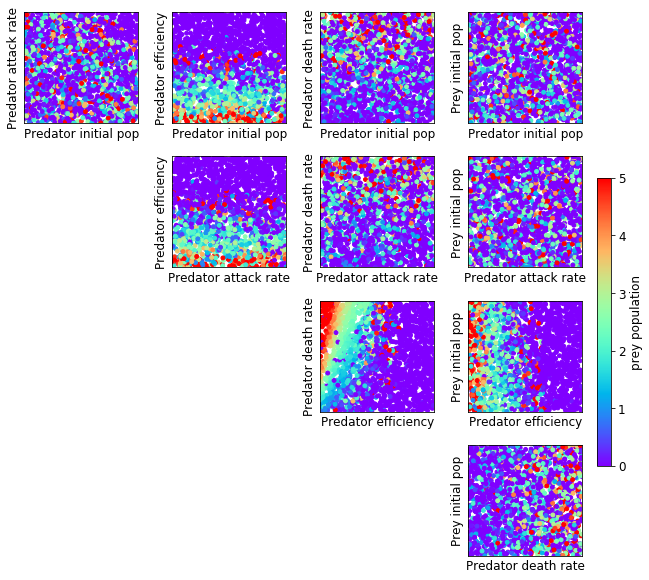

In [18]:
colorscale = 'rainbow' # black and white plot
ms=15
font_size = 12
Y = Y.flatten() # shape (N, )
Labels = [np.nan]*M
for i in range(M):
    Labels[i] = param_names[i]

fig3 = plt.figure(figsize=(10, 10))    
k = 1
for i in range(M-1):
    for j in range(i+1, M, 1):
        plt.subplot(M-1, M-1, k+i)
        map_plot = plt.scatter(X[:, i], X[:, j], s=ms, c=Y, cmap=colorscale,vmin=0, vmax=5)
        plt.xlabel(Labels[i], fontsize = font_size)
        plt.ylabel(Labels[j], fontsize = font_size)
        plt.xlim((np.min(X[:, i]), np.max(X[:, i])))
        plt.ylim((np.min(X[:, j]), np.max(X[:, j])))
        plt.xticks([])
        plt.yticks([])
        k = k + 1
    k = k + i
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.3, wspace=0.3)
# Create colorbar
cax = fig3.add_axes([0.92, 0.05, 0.02, 0.8]) # Add axes for the colorbar
cb = plt.colorbar(map_plot, ax=cax, fraction=1, extendfrac=1, extendrect=True)
cb.set_label(outputs[output.value], fontsize = font_size)
cb.ax.tick_params(labelsize=font_size)
# Make axes of the colorbar invisible
cax.set_visible(False)

### References

1. [SAFE Website](https://www.safetoolbox.info/)
2. [Introductory paper to SAFE - Pianosi et al. (2015)](https://www.sciencedirect.com/science/article/pii/S1364815215001188)
3. [PAWN method - Pianosi and Wagener (2018)](https://doi.org/10.1016/j.envsoft.2018.07.019)
4. [A review of available methods and workflows for Sensitivity Analysis - Pianosi et al. (2016)](https://www.sciencedirect.com/science/article/pii/S1364815216300287)
5. [What has Global Sensitivity Analysis ever done for us? A systematic review to support scientific advancement and to inform policy-making in earth system modelling - Wagener and Pianosi (2019)](https://www.sciencedirect.com/science/article/pii/S0012825218300990)
6. [Global Sensitivity Analysis . The primer - Saltelli et al. (2008)](http://www.andreasaltelli.eu/file/repository/A_Saltelli_Marco_Ratto_Terry_Andres_Francesca_Campolongo_Jessica_Cariboni_Debora_Gatelli_Michaela_Saisana_Stefano_Tarantola_Global_Sensitivity_Analysis_The_Primer_Wiley_Interscience_2008_.pdf) 
7. [Dummy parameter - Zadeh et al. (2017)](https://www.sciencedirect.com/science/article/pii/S1364815217301159)